# Цели:
1. Создание архитектуры с простыми skip-connection'ами
2. Создание архитектуры с DenseBlock'ами (каждый слой получает на вход все предыдущие выходы слоев до него)
3. Создание архитектуры с Inception'ами (т.е. на одном уровне выходы подаются сразу в несколько conv, maxpool и т.д. слоев. Затем их выходы конкатинируются и подаются дальше + модель имеет несколько слоев классификаторов (на разных уровнях, таким образом решается проблема затухания градиентов)
4. Fine-tuning какой-нибудь модели (с заморозкой некоторых слоев)

+ памятка - при fine-tuning'e нужно использовать normalize с того датасета, на котором обучалась изначальная модель.                                                    


Памятка по реализации архитектур:  https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial5/Inception_ResNet_DenseNet.html

In [1]:
#Тут все как в прошлом ED3 до мента построения сети. 
import pandas as pd
import numpy as np
import sklearn
from torch.utils.data import DataLoader, Dataset
import torch
from PIL import Image
import torchvision.transforms as transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
import os
from sklearn.model_selection import KFold
import torch
import seaborn as sns
import torch.nn as nn
from torch.nn import CrossEntropyLoss
device = 'cuda' if torch.cuda.is_available() else 'cpu'
csv = pd.read_csv("../input/plant-pathology-2021-fgvc8/train.csv")
LE = LabelEncoder()
csv = csv.sample(frac=1).reset_index(drop=True)
csv["labels"] = LE.fit_transform(csv["labels"])
csv_val = csv.iloc[:3700, :].reset_index(drop = True)
csv_train = csv.iloc[3700:, :].reset_index(drop = True)
class CustomDataset(Dataset):
    def __init__(self, root_dir, csv, transform = None):
        self.transform = transform
        self.root_dir = root_dir
        self.csv = csv
    
    def __len__(self):
        return len(self.csv)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.csv.iloc[index, 0])
        image = Image.open(img_path)
        y_label = self.csv.iloc[index, 1]
        
        if self.transform:
            image = self.transform(image)
            
        return (image, y_label)
my_transforms = transforms.Compose([
    transforms.Resize((170, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p = 0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4077, 0.6261, 0.4868], std=[0.1962, 0.1652, 0.1883])
])
my_transforms_val = transforms.Compose([
    transforms.Resize((170, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4077, 0.6261, 0.4868], std=[0.1962, 0.1652, 0.1883])
])
train_dataset = CustomDataset(root_dir = "../input/resized-plant2021/img_sz_256", csv = csv_train, transform = my_transforms)
val_dataset = CustomDataset(root_dir = "../input/resized-plant2021/img_sz_256", csv = csv_val, transform = my_transforms_val)
trainloader = DataLoader(dataset = train_dataset, batch_size = 128, shuffle = True)
valloader = DataLoader(dataset = val_dataset, batch_size = 128, shuffle = True)


In [13]:
#1. Пробная, как видим residual и x должны иметь одинаковый shape при конкатинации. Построим сеть с residual skip connection'ами (как в ResNet)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 200, kernel_size = 4, stride = 2)
        self.bn1 = nn.BatchNorm2d(200)
        self.pool1 = nn.MaxPool2d(kernel_size=4, stride=1)
        self.conv2 = nn.Conv2d(in_channels=200, out_channels=100, kernel_size=4)
        self.bn2 = nn.BatchNorm2d(100)
        self.pool2 = nn.MaxPool2d(kernel_size=4, stride=1)
        self.conv3 = nn.Conv2d(in_channels=100, out_channels=200, kernel_size=3, stride = 2)
        self.bn3 = nn.BatchNorm2d(200)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=1)
        self.conv4 = nn.Conv2d(in_channels=200, out_channels=200, kernel_size=6)
        self.bn4 = nn.BatchNorm2d(200)
        self.pool4 = nn.MaxPool2d(kernel_size=6, stride=1)
        self.relu = nn.ReLU()
        
        self.fc1 = nn.Linear(200 * 15 * 5, 512)  # !!!
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 12)
        
    def forward(self, x):
        x = self.pool1(self.relu(self.bn1(self.conv1(x))))
        
        residual1 = x
        
        x = self.pool2(self.relu(self.bn2(self.conv2(x))))
        x = self.pool3(self.relu(self.bn3(self.conv3(x))))
        x = self.pool4(self.relu(self.bn4(self.conv4(x))))
        print(residual1.shape, x.shape)
        x += residual1
        
        residual2 = x
        
        x = self.pool4(self.relu(self.bn4(self.conv4(x))))
        x = self.pool4(self.relu(self.bn4(self.conv4(x))))
        x = self.pool4(self.relu(self.bn4(self.conv4(x))))
        x += residual2
        
        
        
        print(x.shape)
        
        #x = x.view(-1, 200 * 15 * 5)
        #x = self.relu(self.fc1(x))
        #x = self.relu(self.fc2(x))
        #x = self.fc3(x)
        #return x

In [14]:
#Ошибка, т.к. residual и x имеют разные shape
model = CNN()
model(train_dataset[0][0].view(1, 3, 170, 256))

torch.Size([1, 200, 81, 124]) torch.Size([1, 200, 25, 46])


RuntimeError: The size of tensor a (46) must match the size of tensor b (124) at non-singleton dimension 3

In [2]:
#Попробуем исправить эту ошибку. Для этого был посчитан shape после первого слоя conv + bn + maxpool, выходы которого мы хотим добавлять через блок. 
# Теперь нам необходимо чтобы на выходе следующих слоев в блоке (у нас их 3) shape был таким же как у первого слоя на выходе, т.е. [1, 200, 41, 62].
# Для этого будем применять паддинг на каждом conv слое, чтобы после свертки размер изображения оставался тем же 
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 200, kernel_size = 4, stride = 2)
        self.bn1 = nn.BatchNorm2d(200)
        self.pool1 = nn.MaxPool2d(kernel_size=4, stride=2) #OUT:  [1, 200, 41, 62]
        self.conv2 = nn.Conv2d(in_channels=200, out_channels=100, kernel_size=5, padding = 2)
        self.bn2 = nn.BatchNorm2d(100)
        self.pool2 = nn.MaxPool2d(kernel_size=4, stride=1)
        self.conv3 = nn.Conv2d(in_channels=100, out_channels=200, kernel_size=3, stride = 1, padding = 1)
        self.bn3 = nn.BatchNorm2d(200)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=1)
        self.conv4 = nn.Conv2d(in_channels=200, out_channels=200, kernel_size=5, padding = 2)
        self.bn4 = nn.BatchNorm2d(200)
        self.pool4 = nn.MaxPool2d(kernel_size=6, stride=1)
        self.relu = nn.ReLU()
        
        self.fc1 = nn.Linear(200 * 41 * 62, 512)  # !!!
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 12)
        
    def forward(self, x):
        x = self.pool1(self.relu(self.bn1(self.conv1(x))))
        
        residual1 = x
        
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.relu(self.bn4(self.conv4(x)))
        #print(residual1.shape, x.shape)
        x = residual1 + x
        
        residual2 = x
        
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.relu(self.bn4(self.conv4(x)))
        x = residual2 + x
        
        
        
        #print(x.shape)
        
        x = x.view(-1, 200 * 41 * 62)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [21]:
#Теперь работает
model = CNN()
model(train_dataset[0][0].view(1, 3, 170, 256))

torch.Size([1, 200, 41, 62]) torch.Size([1, 200, 41, 62])
torch.Size([1, 200, 41, 62])


In [3]:
model = CNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)
criterion = CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)
num_epochs = 50

best_model_wts = model.state_dict()
best_acc = 0.0
    

losses = {'train': [], "val": []}

# Run the training loop for defined number of epochs
for epoch in range(num_epochs):
    running_loss = 0
    processed_data = 0
    processed_size1 = 0
    running_loss1 = 0
    running_corrects = 0
    for batch_i, (data, target) in tqdm(enumerate(trainloader), total = len(trainloader)):
        data, target = data.to(device), target.to(device)
        model.train()
        optimizer.zero_grad()
        y_pred = model(data)
        loss = criterion(y_pred, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * data.size(0)
        processed_data += data.size(0)
    train_loss = running_loss / processed_data
    model.eval()
    with torch.no_grad():
        for data, target in tqdm(valloader):
            data, target = data.to(device), target.to(device)
            probs = model(data)
            lossfc = criterion(probs, target) 
            running_loss1 += lossfc.item() * data.size(0)
            processed_size1 += data.size(0)
            
            preds = torch.argmax(probs, -1)
            running_corrects += int(torch.sum(preds == target.data))
            
        val_loss = running_loss1 / processed_size1 
        val_acc = running_corrects / processed_size1 
        
        losses["train"].append(train_loss)
        losses["val"].append(val_loss)
        
        if val_acc > best_acc:
                best_acc = val_acc
                best_model_wts = model.state_dict()
    print("Epoch" + " " + str(epoch) + ":", "train_loss:" + str(train_loss), "val_loss:" + str(val_loss), "val_acc:" + str(val_acc))
    scheduler.step()

100%|██████████| 29/29 [00:32<00:00,  1.14s/it]


Epoch 0: train_loss:547206.7710486678 val_loss:10.635558022937259 val_acc:0.2464864864864865


100%|██████████| 29/29 [00:16<00:00,  1.78it/s]


Epoch 1: train_loss:3.0548465513780676 val_loss:6.3621689659840355 val_acc:0.2464864864864865


100%|██████████| 29/29 [00:16<00:00,  1.78it/s]


Epoch 2: train_loss:3.9555412668534204 val_loss:1.910870111439679 val_acc:0.25756756756756755


100%|██████████| 29/29 [00:16<00:00,  1.79it/s]


Epoch 3: train_loss:1.9224399516961226 val_loss:1.9125982480435757 val_acc:0.25756756756756755


100%|██████████| 29/29 [00:16<00:00,  1.77it/s]


Epoch 4: train_loss:1.9215647365719264 val_loss:1.9110948976310524 val_acc:0.25756756756756755


100%|██████████| 29/29 [00:16<00:00,  1.73it/s]


Epoch 5: train_loss:1.919807211502672 val_loss:1.9208182788539576 val_acc:0.25756756756756755


100%|██████████| 29/29 [00:16<00:00,  1.73it/s]


Epoch 6: train_loss:1.9222573138994983 val_loss:1.9115717172622682 val_acc:0.25756756756756755


100%|██████████| 29/29 [00:16<00:00,  1.75it/s]


Epoch 7: train_loss:1.9219617602207564 val_loss:1.917389506391577 val_acc:0.25756756756756755


100%|██████████| 29/29 [00:17<00:00,  1.68it/s]


Epoch 8: train_loss:1.9245648538335027 val_loss:1.910216131468077 val_acc:0.25756756756756755


100%|██████████| 29/29 [00:16<00:00,  1.77it/s]


Epoch 9: train_loss:1.9220581787890094 val_loss:1.9115654621897518 val_acc:0.24675675675675676


100%|██████████| 29/29 [00:16<00:00,  1.75it/s]


Epoch 10: train_loss:1.9215213564615483 val_loss:1.9203469263540731 val_acc:0.25756756756756755


100%|██████████| 29/29 [00:16<00:00,  1.75it/s]


Epoch 11: train_loss:1.919796850673002 val_loss:1.9139385242719908 val_acc:0.24675675675675676


100%|██████████| 29/29 [00:16<00:00,  1.74it/s]


Epoch 12: train_loss:1.9208505059450969 val_loss:1.919945658219827 val_acc:0.24675675675675676


100%|██████████| 29/29 [00:16<00:00,  1.76it/s]


Epoch 13: train_loss:1.9189840755736 val_loss:1.9229866746954016 val_acc:0.24675675675675676


100%|██████████| 29/29 [00:16<00:00,  1.75it/s]


Epoch 14: train_loss:1.9198261220941204 val_loss:1.9204015872285172 val_acc:0.24675675675675676


100%|██████████| 29/29 [00:16<00:00,  1.74it/s]


Epoch 15: train_loss:1.9207916291060858 val_loss:1.917996669846612 val_acc:0.25756756756756755


100%|██████████| 29/29 [00:16<00:00,  1.74it/s]


Epoch 16: train_loss:1.9208987296314173 val_loss:1.9140548386444916 val_acc:0.25756756756756755


 50%|█████     | 59/117 [00:57<00:56,  1.03it/s]


KeyboardInterrupt: 

Так обычно выглядит структура: (оранжевые блоки начинаются с любого слоя, уменьшающего размерность. Тут например conv 1x1 stride = 2)
Внутри же блоков размерность от входа до выхода одинаковая

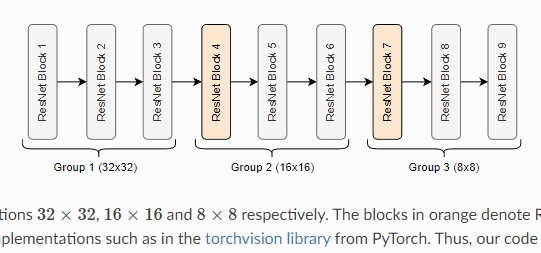

In [ ]:
#2. архитектура с dense block'ами 
class DenseLayer(nn.Module):

    def __init__(self, c_in, bn_size, growth_rate, act_fn):
        """
        Inputs:
            c_in - Number of input channels
            bn_size - Bottleneck size (factor of growth rate) for the output of the 1x1 convolution. Typically between 2 and 4.
            growth_rate - Number of output channels of the 3x3 convolution
            act_fn - Activation class constructor (e.g. nn.ReLU)
        """
        super().__init__()
        self.net = nn.Sequential(
            nn.BatchNorm2d(c_in),
            act_fn(),
            nn.Conv2d(c_in, bn_size * growth_rate, kernel_size=1, bias=False),
            nn.BatchNorm2d(bn_size * growth_rate),
            act_fn(),
            nn.Conv2d(bn_size * growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)
        )

    def forward(self, x):
        out = self.net(x)
        out = torch.cat([out, x], dim=1)
        return out

class DenseBlock(nn.Module):

    def __init__(self, c_in, num_layers, bn_size, growth_rate, act_fn):
        """
        Inputs:
            c_in - Number of input channels
            num_layers - Number of dense layers to apply in the block
            bn_size - Bottleneck size to use in the dense layers
            growth_rate - Growth rate to use in the dense layers
            act_fn - Activation function to use in the dense layers
        """
        super().__init__()
        layers = []
        for layer_idx in range(num_layers):
            layers.append(
                DenseLayer(c_in=c_in + layer_idx * growth_rate, # Input channels are original plus the feature maps from previous layers
                           bn_size=bn_size,
                           growth_rate=growth_rate,
                           act_fn=act_fn)
            )
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        out = self.block(x)
        return out
    
class TransitionLayer(nn.Module):

    def __init__(self, c_in, c_out, act_fn):
        super().__init__()
        self.transition = nn.Sequential(
            nn.BatchNorm2d(c_in),
            act_fn(),
            nn.Conv2d(c_in, c_out, kernel_size=1, bias=False),
            nn.AvgPool2d(kernel_size=2, stride=2) # Average the output for each 2x2 pixel group
        )

    def forward(self, x):
        return self.transition(x)
    
    
class DenseNet(nn.Module):

    def __init__(self, num_classes=10, num_layers=[6,6,6,6], bn_size=2, growth_rate=16, act_fn_name="relu", **kwargs):
        super().__init__()
        self.hparams = SimpleNamespace(num_classes=num_classes,
                                       num_layers=num_layers,
                                       bn_size=bn_size,
                                       growth_rate=growth_rate,
                                       act_fn_name=act_fn_name,
                                       act_fn=act_fn_by_name[act_fn_name])
        self._create_network()
        self._init_params()

    def _create_network(self):
        c_hidden = self.hparams.growth_rate * self.hparams.bn_size # The start number of hidden channels

        # A first convolution on the original image to scale up the channel size
        self.input_net = nn.Sequential(
            nn.Conv2d(3, c_hidden, kernel_size=3, padding=1) # No batch norm or activation function as done inside the Dense layers
        )

        # Creating the dense blocks, eventually including transition layers
        blocks = []
        for block_idx, num_layers in enumerate(self.hparams.num_layers):
            blocks.append(
                DenseBlock(c_in=c_hidden,
                           num_layers=num_layers,
                           bn_size=self.hparams.bn_size,
                           growth_rate=self.hparams.growth_rate,
                           act_fn=self.hparams.act_fn)
            )
            c_hidden = c_hidden + num_layers * self.hparams.growth_rate # Overall output of the dense block
            if block_idx < len(self.hparams.num_layers)-1: # Don't apply transition layer on last block
                blocks.append(
                    TransitionLayer(c_in=c_hidden,
                                    c_out=c_hidden // 2,
                                    act_fn=self.hparams.act_fn))
                c_hidden = c_hidden // 2

        self.blocks = nn.Sequential(*blocks)

        # Mapping to classification output
        self.output_net = nn.Sequential(
            nn.BatchNorm2d(c_hidden), # The features have not passed a non-linearity until here.
            self.hparams.act_fn(),
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(c_hidden, self.hparams.num_classes)
        )

    def _init_params(self):
        # Based on our discussion in Tutorial 4, we should initialize the convolutions according to the activation function
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, nonlinearity=self.hparams.act_fn_name)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.input_net(x)
        x = self.blocks(x)
        x = self.output_net(x)
        return x


In [ ]:
#3 Inception блоки. как добавить еще несколько классификатор на разных уровнях - https://jaketae.github.io/study/pytorch-inception/
class InceptionBlock(nn.Module):

    def __init__(self, c_in, c_red : dict, c_out : dict, act_fn):
        """
        Inputs:
            c_in - Number of input feature maps from the previous layers
            c_red - Dictionary with keys "3x3" and "5x5" specifying the output of the dimensionality reducing 1x1 convolutions
            c_out - Dictionary with keys "1x1", "3x3", "5x5", and "max"
            act_fn - Activation class constructor (e.g. nn.ReLU)
        """
        super().__init__()

        # 1x1 convolution branch
        self.conv_1x1 = nn.Sequential(
            nn.Conv2d(c_in, c_out["1x1"], kernel_size=1),
            nn.BatchNorm2d(c_out["1x1"]),
            act_fn()
        )

        # 3x3 convolution branch
        self.conv_3x3 = nn.Sequential(
            nn.Conv2d(c_in, c_red["3x3"], kernel_size=1),
            nn.BatchNorm2d(c_red["3x3"]),
            act_fn(),
            nn.Conv2d(c_red["3x3"], c_out["3x3"], kernel_size=3, padding=1),
            nn.BatchNorm2d(c_out["3x3"]),
            act_fn()
        )

        # 5x5 convolution branch
        self.conv_5x5 = nn.Sequential(
            nn.Conv2d(c_in, c_red["5x5"], kernel_size=1),
            nn.BatchNorm2d(c_red["5x5"]),
            act_fn(),
            nn.Conv2d(c_red["5x5"], c_out["5x5"], kernel_size=5, padding=2),
            nn.BatchNorm2d(c_out["5x5"]),
            act_fn()
        )

        # Max-pool branch
        self.max_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
            nn.Conv2d(c_in, c_out["max"], kernel_size=1),
            nn.BatchNorm2d(c_out["max"]),
            act_fn()
        )

    def forward(self, x):
        x_1x1 = self.conv_1x1(x)
        x_3x3 = self.conv_3x3(x)
        x_5x5 = self.conv_5x5(x)
        x_max = self.max_pool(x)
        x_out = torch.cat([x_1x1, x_3x3, x_5x5, x_max], dim=1)
        return x_out

class GoogleNet(nn.Module):

    def __init__(self, num_classes=10, act_fn_name="relu", **kwargs):
        super().__init__()
        self.hparams = SimpleNamespace(num_classes=num_classes,
                                       act_fn_name=act_fn_name,
                                       act_fn=act_fn_by_name[act_fn_name])
        self._create_network()
        self._init_params()

    def _create_network(self):
        # A first convolution on the original image to scale up the channel size
        self.input_net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            self.hparams.act_fn()
        )
        # Stacking inception blocks
        self.inception_blocks = nn.Sequential(
            InceptionBlock(64, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 32, "5x5": 8, "max": 8}, act_fn=self.hparams.act_fn),
            InceptionBlock(64, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}, act_fn=self.hparams.act_fn),
            nn.MaxPool2d(3, stride=2, padding=1),  # 32x32 => 16x16
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}, act_fn=self.hparams.act_fn),
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 48, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn),
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 48, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn),
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 32, "3x3": 48, "5x5": 24, "max": 24}, act_fn=self.hparams.act_fn),
            nn.MaxPool2d(3, stride=2, padding=1),  # 16x16 => 8x8
            InceptionBlock(128, c_red={"3x3": 48, "5x5": 16}, c_out={"1x1": 32, "3x3": 64, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn),
            InceptionBlock(128, c_red={"3x3": 48, "5x5": 16}, c_out={"1x1": 32, "3x3": 64, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn)
        )
        # Mapping to classification output
        self.output_net = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, self.hparams.num_classes)
        )

    def _init_params(self):
        # Based on our discussion in Tutorial 4, we should initialize the convolutions according to the activation function
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, nonlinearity=self.hparams.act_fn_name)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.input_net(x)
        x = self.inception_blocks(x)
        x = self.output_net(x)
        return x

In [2]:
# Теперь transfer learning на примере AlexNet
#Сначала просто fine-tuning (без заморозки слоев)
import torchvision
from torchvision import datasets, models, transforms
model = models.alexnet(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
#можем заменить как весь блок classifier:
model.classifier = nn.Linear(9216, 12)

In [6]:
#так и отдельный слой в этом блоке: (воспользуемся этим способом)
model.classifier[6] = nn.Linear(4096, 12)
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [9]:
#Перед обучением нам нужно немного переделать аугментацию, т.к. изображения в alexnet подаются 227х227. Сначала посмотрим что станет с нашими 170x256
#после такого ресайза (будут ли они адекватными) + используем normalize по статистикам imagenet
img = Image.open("../input/resized-plant2021/img_sz_256/800113bb65efe69e.jpg")

preprocess = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

x = preprocess(img)
x.shape

torch.Size([3, 227, 227])

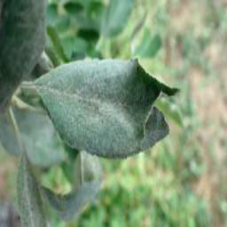

In [10]:
#выглядит вполне нормально
def renormalize(tensor):
        minFrom= tensor.min()
        maxFrom= tensor.max()
        minTo = 0
        maxTo=1
        return minTo + (maxTo - minTo) * ((tensor - minFrom) / (maxFrom - minFrom))
x = renormalize(x)
transform = transforms.ToPILImage()
img = transform(x)
img

In [11]:
#Тогда переписываем датасет под нужную аугментацию и попробуем начать train:
my_transforms = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p = 0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
my_transforms_val = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_dataset = CustomDataset(root_dir = "../input/resized-plant2021/img_sz_256", csv = csv_train, transform = my_transforms)
val_dataset = CustomDataset(root_dir = "../input/resized-plant2021/img_sz_256", csv = csv_val, transform = my_transforms_val)
trainloader = DataLoader(dataset = train_dataset, batch_size = 128, shuffle = True)
valloader = DataLoader(dataset = val_dataset, batch_size = 128, shuffle = True)

In [13]:
#Все работает и обучается
optimizer = torch.optim.Adam(model.parameters(), lr=3e-2)
criterion = CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)
num_epochs = 50

best_model_wts = model.state_dict()
best_acc = 0.0
    

losses = {'train': [], "val": []}

# Run the training loop for defined number of epochs
for epoch in range(num_epochs):
    running_loss = 0
    processed_data = 0
    processed_size1 = 0
    running_loss1 = 0
    running_corrects = 0
    for batch_i, (data, target) in tqdm(enumerate(trainloader), total = len(trainloader)):
        data, target = data.to(device), target.to(device)
        model.train()
        optimizer.zero_grad()
        y_pred = model(data)
        loss = criterion(y_pred, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * data.size(0)
        processed_data += data.size(0)
    train_loss = running_loss / processed_data
    model.eval()
    with torch.no_grad():
        for data, target in tqdm(valloader):
            data, target = data.to(device), target.to(device)
            probs = model(data)
            lossfc = criterion(probs, target) 
            running_loss1 += lossfc.item() * data.size(0)
            processed_size1 += data.size(0)
            
            preds = torch.argmax(probs, -1)
            running_corrects += int(torch.sum(preds == target.data))
            
        val_loss = running_loss1 / processed_size1 
        val_acc = running_corrects / processed_size1 
        
        losses["train"].append(train_loss)
        losses["val"].append(val_loss)
        
        if val_acc > best_acc:
                best_acc = val_acc
                best_model_wts = model.state_dict()
    print("Epoch" + " " + str(epoch) + ":", "train_loss:" + str(train_loss), "val_loss:" + str(val_loss), "val_acc:" + str(val_acc))
    scheduler.step()

100%|██████████| 29/29 [00:35<00:00,  1.22s/it]


Epoch 0: train_loss:64137220.143614024 val_loss:1.9234061980891872 val_acc:0.2572972972972973


100%|██████████| 29/29 [00:14<00:00,  2.03it/s]


Epoch 1: train_loss:1993.564472743151 val_loss:1.8991653483622783 val_acc:0.2572972972972973


100%|██████████| 29/29 [00:14<00:00,  2.06it/s]


Epoch 2: train_loss:26011.826690083242 val_loss:1.8976922053259773 val_acc:0.2572972972972973


 21%|██        | 24/117 [00:13<00:53,  1.74it/s]


KeyboardInterrupt: 

In [17]:
#Теперь feature extractor метод (т.е. с заморозкой)
# сначала посмотрим что везде grad = true
model = models.alexnet(pretrained=True)
for param in model.parameters():
    print(param.requires_grad)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [19]:
#заморозим сверточные слои (это можно сделать и циклом по каждому параметру)
model.features.requires_grad_(False)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [ ]:
#цикл для заморозки всех, потом отдельные можно разморозить
#for param in model.parameters():
#    param.requires_grad = False
#model

In [21]:
#Посмотрим, что все выполнилось
for param in model.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True


In [22]:
#Заменим последний fcn слой
model.classifier[6] = nn.Linear(4096, 12)
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
#Все работает и обучается
optimizer = torch.optim.Adam(model.parameters(), lr=3e-2)
criterion = CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)
num_epochs = 50

best_model_wts = model.state_dict()
best_acc = 0.0
    

losses = {'train': [], "val": []}

# Run the training loop for defined number of epochs
for epoch in range(num_epochs):
    running_loss = 0
    processed_data = 0
    processed_size1 = 0
    running_loss1 = 0
    running_corrects = 0
    for batch_i, (data, target) in tqdm(enumerate(trainloader), total = len(trainloader)):
        data, target = data.to(device), target.to(device)
        model.train()
        optimizer.zero_grad()
        y_pred = model(data)
        loss = criterion(y_pred, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * data.size(0)
        processed_data += data.size(0)
    train_loss = running_loss / processed_data
    model.eval()
    with torch.no_grad():
        for data, target in tqdm(valloader):
            data, target = data.to(device), target.to(device)
            probs = model(data)
            lossfc = criterion(probs, target) 
            running_loss1 += lossfc.item() * data.size(0)
            processed_size1 += data.size(0)
            
            preds = torch.argmax(probs, -1)
            running_corrects += int(torch.sum(preds == target.data))
            
        val_loss = running_loss1 / processed_size1 
        val_acc = running_corrects / processed_size1 
        
        losses["train"].append(train_loss)
        losses["val"].append(val_loss)
        
        if val_acc > best_acc:
                best_acc = val_acc
                best_model_wts = model.state_dict()
    print("Epoch" + " " + str(epoch) + ":", "train_loss:" + str(train_loss), "val_loss:" + str(val_loss), "val_acc:" + str(val_acc))
    scheduler.step()

100%|██████████| 29/29 [00:17<00:00,  1.61it/s]


Epoch 0: train_loss:309.9678617922448 val_loss:1.8307615726058548 val_acc:0.29864864864864865


100%|██████████| 29/29 [00:14<00:00,  1.95it/s]


Epoch 1: train_loss:2.2616242564398323 val_loss:1.9051503129907557 val_acc:0.2562162162162162


100%|██████████| 29/29 [00:15<00:00,  1.93it/s]


Epoch 2: train_loss:2.0439377964708525 val_loss:1.8980552910469675 val_acc:0.2572972972972973


100%|██████████| 29/29 [00:14<00:00,  1.98it/s]


Epoch 3: train_loss:1.9178742674889655 val_loss:1.8979047204352715 val_acc:0.2572972972972973


100%|██████████| 29/29 [00:15<00:00,  1.91it/s]


Epoch 4: train_loss:1.9367915770338842 val_loss:1.898563925768878 val_acc:0.2572972972972973


100%|██████████| 29/29 [00:14<00:00,  1.95it/s]


Epoch 5: train_loss:1.9180397075333226 val_loss:1.8973475965293678 val_acc:0.2572972972972973


 42%|████▏     | 49/117 [00:27<00:37,  1.79it/s]